# Install Dependencies

In [1]:
!pip install -U sentence-transformers
!pip install sklearn
!pip install plotly
!pip install nbformat>=4.2.0
!pip install matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import Dependencies

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

d:\Development\Python-Mini-Projects\SemanticClustering\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Cleaning

In [43]:
def data_cleaning(input_file, output_file):
    list_data = ["<br/>","Hi team -","hi team -","Hello-","Hi Team,","Hi team,","Hello,","Hi Team:","Hello Team,","Hi,","Hi team-",
                 "Hi Team-","Hi Team.","Hello,","hello,","Hi Team","hi team","hello team","Hello!","team,","Team","====","HI","Hi team"]

    with open(input_file, 'r') as file:
        data = file.read()
        for l_data in list_data:
            data = data.replace(l_data, "")

    # Opening our text file in write only mode to write the replaced content
    with open(output_file, 'w') as file:
        file.write(data)

    df = pd.read_csv(output_file)
    # Renaming the column
    df.rename(columns={"First Comment": "comments"}, inplace=True)
    # Removing blank rows
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.to_csv(output_file, index=False)
    number_of_rows_input_file = pd.read_csv(input_file).shape[0]
    number_of_rows_output_file = pd.read_csv(output_file).shape[0]
    print(f"Number of rows in {input_file} = {number_of_rows_input_file}\n" +
          f"Number of rows in {output_file} = {number_of_rows_output_file}\n" +
          f"Number of rows dropped = {number_of_rows_input_file - number_of_rows_output_file}\n")
    print(f"Data cleaning complete. Cleaned data is stored in {output_file}")

In [44]:
data_cleaning("./Data/Raw_Dataset.csv", "./Data/Cleaned_Dataset.csv")

Number of rows in ./Data/Raw_Dataset.csv = 8665
Number of rows in ./Data/Cleaned_Dataset.csv = 8620
Number of rows dropped = 45

Data cleaning complete. Cleaned data is stored in ./Data/Cleaned_Dataset.csv


In [15]:
# Add id column to the dataset (Extra)

df_raw = pd.read_csv("./Data/Cleaned_Dataset.csv")

# Add the 'id' column with incrementing numbers starting from 1
df_raw['id'] = range(1, len(df_raw) + 1)

# Save the updated dataset back to CSV
df_raw.to_csv("./Data/Cleaned_Dataset.csv", index=False)

In [6]:
# Converting the cleaned dataset into list

df1 = pd.read_csv("./Data/Cleaned_Dataset.csv")
comments_list = df1.comments.tolist()

# Model to create, store, and read embeddings

In [7]:
def create_and_store_embeddings() -> np.ndarray:
    model = SentenceTransformer('all-MiniLM-L6-v2')
    # model = SentenceTransformer('distilbert-base-nli-stsb-quora-ranking') # Use for different results
    embeddings = model.encode(comments_list, show_progress_bar=True)
    # Normalize the embeddings to unit length
    embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True)
    return embeddings

In [8]:
embeddings = create_and_store_embeddings()

Batches: 100%|██████████| 270/270 [04:31<00:00,  1.01s/it]


In [9]:
# Store sentences and embeddings to disc
with open("./Data/embeddings.pkl", "wb") as fOut:
    pickle.dump({'sentences': comments_list, 'embeddings': embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
#Load sentences & embeddings from disc
embeddings = np.empty_like(embeddings)
with open("./Data/embeddings.pkl", "rb") as fIn:
    stored_data = pickle.load(fIn)
    stored_sentences = stored_data['sentences']
    embeddings = stored_data['embeddings']

# Detect Clusters

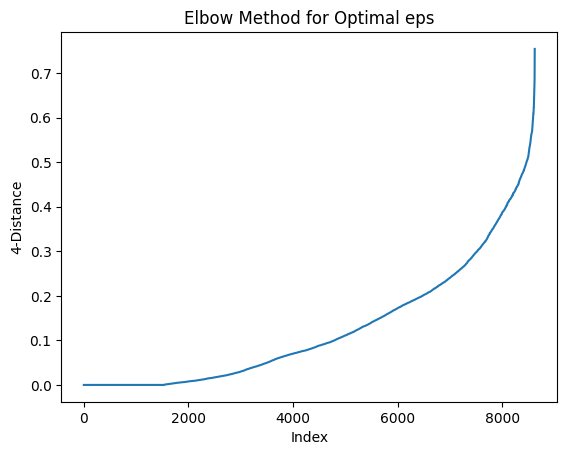

In [11]:
def find_optimal_eps(embeddings, k=4):
    """
    1) Compute the k-distance graph: Calculate the distance between each point and its kth nearest neighbor (e.g., k=4).
    2) Sort the distances in ascending order and plot them.
    3) Look for the "elbow point" in the plot, which is the point where the curve starts to bend or the rate of change in distances decreases significantly.
    4) Use the distance value at the elbow point as the eps value for DBSCAN.
    """
    neighbors = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    neighbors_fit = neighbors.fit(embeddings)
    distances, _ = neighbors_fit.kneighbors(embeddings)
    sorted_distances = np.sort(distances[:, -1], axis=0)
    
    plt.plot(sorted_distances)
    plt.xlabel('Index')
    plt.ylabel(f'{k}-Distance')
    plt.title(f'Elbow Method for Optimal eps')
    plt.show()

# Call the function to visualize the elbow point and identify the optimal eps
find_optimal_eps(embeddings, k=4)


In [12]:
def detect_clusters_dbscan(embeddings, eps=0.2, min_samples=10):
    """
    1) The eps parameter controls the maximum distance between two points for them to be considered part of the same neighborhood (i.e., cluster).
    2) The min_samples parameter determines the minimum number of points required to form a dense region, effectively determining the minimum size of a cluster.
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    cluster_labels = dbscan.fit_predict(embeddings)
    unique_communities = []
    for label in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == label)[0]
        if len(cluster_indices) >= min_samples:
            unique_communities.append(cluster_indices.tolist())
    return unique_communities

uniques_comm = detect_clusters_dbscan(embeddings, eps=0.3, min_samples=30)

## Save sentences per cluster into seperate file

In [13]:
def write_cluster_sentences_to_file(comments_list, unique_communities, df_input):
    cluster_count = 1
    total_sentences_in_cluster = 0
    df_input['cluster'] = -1  # Initialize the 'cluster' column with -1 for all rows
    for cluster in unique_communities:
        length_of_cluster = len(cluster)
        total_sentences_in_cluster += length_of_cluster
        print(f"Cluster {cluster_count} = {length_of_cluster}")
        for index in cluster:
            sentence = comments_list[index]
            id_value = df_input.iloc[index]['id']
            df_input.at[index, 'cluster'] = cluster_count  # Assign cluster number to the 'cluster' column
        cluster_count += 1

    print(f"Total sentences inside all clusters = {total_sentences_in_cluster}")

    # Export the updated DataFrame to a CSV file
    df_input.to_csv("./Output/cluster_number_data.csv", index=False)


In [14]:
write_cluster_sentences_to_file(comments_list, uniques_comm, df1)

Cluster 1 = 1525
Cluster 2 = 6061
Cluster 3 = 82
Cluster 4 = 69
Cluster 5 = 287
Cluster 6 = 265
Cluster 7 = 142
Cluster 8 = 47
Cluster 9 = 56
Cluster 10 = 47
Cluster 11 = 39
Total sentences inside all clusters = 8620


# Plot Clusters

In [16]:
def plot_clusters(clusters_to_show):
    NUM_CLUSTERS_TO_USE = len(clusters_to_show)
    print(f"Number of clusters to use: {NUM_CLUSTERS_TO_USE}")
    # if NUM_CLUSTERS_TO_USE > 20:
    #     NUM_CLUSTERS_TO_USE = 20

    sum = 0
    for cluster in clusters_to_show[:NUM_CLUSTERS_TO_USE]:
        sum += len(cluster)

    percentages = []
    for cluster in clusters_to_show:
        percentages.append((len(cluster)/sum)*100.0)

    labels = [f"Cluster{i}" for i in range(1, NUM_CLUSTERS_TO_USE)]
    values = percentages

    fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
    fig.update_layout(width = 720, height = 720)

    return fig

In [17]:
# Plot the created clusters in pie chart

plot_clusters(uniques_comm)

Number of clusters to use: 11
